In [11]:
!unzip Datasets.zip -d Sexism_Detection_NLP

/bin/bash: unzip: command not found


In [12]:
import zipfile
with zipfile.ZipFile("Datasets.zip","r") as zip_ref:
    zip_ref.extractall("")

Importing Libraries

In [21]:
import time
import os
import markov
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk             # importing natural language toolkit library, useful in various data preprocessing tasks
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from markov.api.model import ModelRecorder   # importing Model recorder from markov, used for experiment recording
from markov.api.recording.experiments.integrations.keras.keras_auto_record import auto_record
# from markov.api.recording.integrations.keras.keras_auto_record import auto_record
from markov.api.schemas.model_recording import ModelRecordingConfig, SingleTagInferenceRecord
import pandas as pd 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # used for making Logistic regression model
from sklearn import tree  # used for making Decision Tree model

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# read file
filepath = os.path.join(os.path.curdir, "Datasets", "Initial_Dataset.csv")
df = pd.read_csv(filepath)
df.head()
len(df)

14000

Data Preprocessing

In [23]:
def clean_text(text):
    """Removes HTML tags and removes punctuation from the text"""
    text = text.lower() 
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text) 
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text) 
    return text

def remove_stopword(text, stopwords):
    """Removes common words such as "the" and "a" from the text"""
    return " ".join([word for word in text.split() if word not in (stop_words)])

def lemma_text(text, lemmatizer):
    """Reduces words to their base forms using lemmatization"""
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
    return " ".join(lemmatized_words)

def tokenize(text):
    """Splits the text into individual words"""
    return text.split()

def process_text(text, lemmatizer, stop_words):
    """Combines the functions to clean and preprocess the text"""
    text = clean_text(text)
    text = remove_stopword(text, stop_words)
    text = lemma_text(text, lemmatizer)
    return text 

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [24]:
# stores the result in a new column called 'processed_text'
df["processed_text"] = df['text'].apply(process_text, lemmatizer = lemmatizer, stop_words = stop_words)
df.head(10)

,text,label_sexist,processed_text
0,"Damn, this writing was pretty chaotic",not sexist,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,yeah apparently bunch misogynistic virgin one ...
2,How the FUCK is this woman still an MP!!!???,not sexist,fuck woman still mp
3,Understand. Know you're right. At same time I ...,not sexist,understand know youre right time know isnt eno...
4,Surprized they didn't stop and rape some women,not sexist,surprized didnt stop rape woman
5,yeah but in order to keep the benefit i have t...,not sexist,yeah order keep benefit good tommorow told cou...
6,Hahaha I just wish they would live their truth...,not sexist,hahaha wish would live truth cut shit wouldnt ...
7,head mod said she talked to him after he made ...,not sexist,head mod said talked made post wont tell anyon...
8,"just the inside of your wallet: cash, bank car...",sexist,inside wallet cash bank card credit card debit...
9,We most definitely did. I didn’t go too much i...,not sexist,definitely didnt go much detail happened put s...


In [25]:
# Under sampling the data
# class count
class_notsexist, class_sexist = df['label_sexist'].value_counts()
class_notsexist, class_sexist

# Separate class
class_s = df[df['label_sexist'] == "sexist"]
class_ns = df[df['label_sexist'] == "not sexist"]
print('class_sexist:', class_s.shape)
print('class_notsexist:', class_ns.shape)

class_sexist: (3398, 3)
class_notsexist: (10602, 3)


<AxesSubplot:title={'center':'count (target)'}>

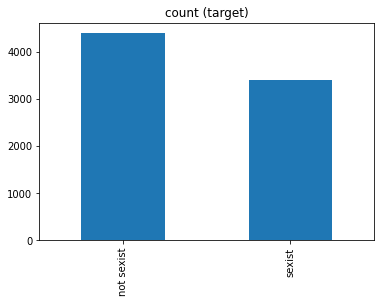

In [26]:
# 1000 additional samples, this is done to address imbalanced classes
class_ns_under = class_ns.sample(class_sexist+1000)
df_under = pd.concat([class_ns_under, class_s], axis=0)
df_under['label_sexist'].value_counts().plot(kind='bar', title='count (target)')

In [27]:
# To create feature vectors from the preprocessed text data.
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df_under.processed_text)

In [28]:
# splits the data into training and test sets
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(tfidf_text_vec, df_under['label_sexist'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)


Logistic Regression

In [29]:
LR_model = f"model_1_LR{int(time.time())}"
LR_recorder = markov.ExperimentRecorder(name=LR_model, notes=f"Logistic Regression: {LR_model}")
# auto_record(name=MODEL_NAME, notes=f"Auto Recording Keras Model with Name: {MODEL_NAME}"
#                                    f" with Sentence Encoder")

✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/experiments/hp-7HhrVVmTVwBsvWotx3KDvAE]8;;\


In [30]:
with LR_recorder:
    lrm = LogisticRegression(penalty='l2', random_state=0).fit(x_train_a, y_train_a)

# prediction on test data 
lrm_pred = lrm.predict(x_test_a)

# estimate accuracy between predicted and actual test data
acc = accuracy_score(lrm_pred, y_test_a)  
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, lrm_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, lrm_pred, output_dict=True)).transpose()

#save the report
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_logistic_reg.csv"), index= True)

ℹ Starting recorder to track training data on markov backend.
✔ Please wait while we send the remaining data to the markov backend... Recording has successfully completed.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/experiments/hp-7HhrVVmTVwBsvWotx3KDvAE]8;;\
Accuracy: 74.29%
              precision    recall  f1-score   support

  not sexist       0.72      0.88      0.80       883
      sexist       0.79      0.56      0.65       677

    accuracy                           0.74      1560
   macro avg       0.75      0.72      0.72      1560
weighted avg       0.75      0.74      0.73      1560



Decision Tree


In [ ]:
DT_model = f"model_1_DT{int(time.time())}"
DT_recorder = markov.ExperimentRecorder(name=DT_model, notes=f"Decision Tree: {DT_model}")
# auto_record(name=MODEL_NAME, notes=f"Auto Recording Keras Model with Name: {MODEL_NAME}"
#                                    f" with Sentence Encoder")

In [ ]:
with DT_recorder:
    dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_features=20)
    dt_clf.fit(x_train_a, y_train_a)

# prediction on test data 
pred = dt_clf.predict(x_test_a)

# estimate accuracy between predicted and actual test data
acc = accuracy_score(pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, pred, output_dict=True)).transpose()

#save the report
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_cls_report_logistic_decision_tree.csv"), index= True)